# 안녕하세요^^ 
# AIVLE 미니 프로젝트3차 팀 미션입니다. 
# 주어진 문제를 잘 읽고 해결하시길 바랍니다.


## 올레TV 예능 콘텐츠 중 하나인 프로그램 "코미디빅리그"의 영상을 분석하고 코너를 분류하는 AI 모델을 만들어 보세요.

"코미디빅리그" 는 tvN에서 방영 중인 서바이벌 형식의 공개 코미디 프로그램으로 3개월 단위로 인기 코너를 선정하는 방식인 쿼제를 도입하고 있다. 
이번 과제는 2022년 1쿼터(1~3월) 방영분 중 2월 방영한 3편을 학습 데이터로 하여 3월 방송의 코너 구간을 추출해내는 것입니다.

아래의 조건들을 참고하여 문제를 해결하세요.
> - 주어진 데이터 ( Train 데이터 :  2월 방영분 3편 / Test 데이터 : 3월 방영분 1편 )
> - 제출 파일은 <font color="red">.ipynb 파일</font>과  조에서 각 과정마다 문제 해결을 위해 진행한 방법을 정리한 <font color="red">발표자료(.pptx)</font>를 포함히여 제출합니다.<br> 
①데이터 분석 및 학습데이터 생성, ②데이터 전처리, ③AI 모델링(아키텍처, 성능비교), ④분류 결과 <br> 
※ 각 과정은 문제 해결 방법에 따라 변경 가능<br><br>
> <b>제출 파일( 압축파일명 : [팀]미니프로젝트3차_AI 0반_00조.zip) </b> <br>
>> ① 코드 : [팀]미니프로젝트3차_AI 0반_00조.ipynb <br>
>> ② 발표자료 : [팀]미니프로젝트3차_AI 0반 00조.pptx <br>




---

# 0. 환경 설정하기

### 1) 구글 드라이브 연결하기

In [1]:
# 코랩 사용 시 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2) 경로 확인하기

In [2]:
# ROOT_PATH 확인 
import os

if os.getcwd() == '/content' :
  # 구글 드라이브 사용 시 
  ROOT_PATH = "/content/drive/MyDrive/AIVLE_3rd[Team]"
else :
  ROOT_PATH = os.path.abspath('..')

# 비디오 파일이 저장되어 있는 폴더
VIDEO_PATH = ROOT_PATH + "/video"
# 모델 학습을 위한 데이터 
TRAIN_PATH = ROOT_PATH + "/train"
# 모델 예측을 위한 test 데이터
TEST_PATH = ROOT_PATH + "/test"
# 이미지 파일 저장된 폴더
IMAGE_PATH = ROOT_PATH + "/image"

### 3) 영상 데이터 다운로드하기
아래 코드를 실행하세요.

In [4]:
# # test data 다운로드
# !pip install gdown

# import gdown
# import shutil

# google_path = 'https://drive.google.com/uc?id='

# file_id = "1p4up6pPd0NqUIaf6mlc2mq12r6NYGDOI"
# output_name = 'video.zip'

# gdown.download(google_path+file_id,output_name,quiet=False)

# shutil.move("./" + output_name, ROOT_PATH)

# import zipfile

# with zipfile.ZipFile(ROOT_PATH + "/video.zip") as z:
#     z.extractall(ROOT_PATH)


# 미니프로젝트 3차 팀 미션 지금부터 시작하세요!

In [3]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

import tensorflow.keras as keras


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

import random as rd

from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [4]:
# 여기에서부터 입력하세요.
dir = Path(ROOT_PATH + '/train')
filepath = list(dir.glob(r'**/*.jpg'))
def proc_img(filepath):

    # 이미지데이터의 경로와 label데이터로 데이터프레임 만들기 

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

df = proc_img(filepath)
df.head(5)

print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 1720

Number of different labels: 5

Labels: ['discussion' 'enter' 'opening_ending' 'chorus' 'boss']


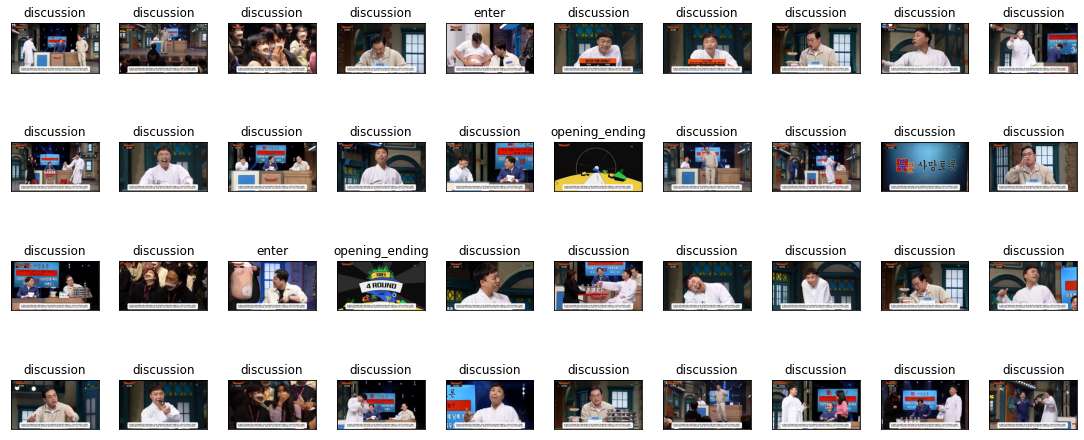

In [5]:
# 데이터 확인
# 이미지 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [6]:
#  Training/test split
# 테스트 데이터로 해볼 것.
#  train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
train_df,test_df = train_test_split(df,random_state=2022, test_size=0.2)
train_df.shape,test_df.shape

((1376, 2), (344, 2))

In [7]:
im = cv2.imread(ROOT_PATH + '/train/discussion/1601.jpg')
print(im.shape)

(480, 854, 3)


In [8]:
img_height = 480
img_width = 854

In [9]:
train_datagen = ImageDataGenerator(rescale = 1. /255,
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(ROOT_PATH + '/train',
                                                 target_size = (img_height, img_width),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training',
                                                 shuffle = True)

val_genertor  = train_datagen.flow_from_directory(ROOT_PATH + '/train',
                                                 target_size = (img_height, img_width),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation',
                                                  shuffle = False)

Found 1376 images belonging to 5 classes.
Found 344 images belonging to 5 classes.


In [15]:
keras.backend.clear_session()
model = keras.models.Sequential()

model.add(keras.layers.Input(shape = (img_height,img_width,3 )))
model.add(keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(keras.layers.Dropout(rate = 0.25))

# pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation = 'swish'))
model.add(keras.layers.Dense(32, activation = 'swish'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(rate = 0.25))

model.add(keras.layers.Dense(5, activation = 'softmax'))


model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adam(), metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 480, 854, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 480, 854, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 240, 427, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 240, 427, 32)      0         
                                                                 
 flatten (Flatten)           (None, 3279360)           0         
                                                                 
 dense (Dense)               (None, 32)                1

In [11]:
MODEL_PATH = 'ROOT_PATH' + '/model'

In [16]:
es = EarlyStopping(
    verbose = 1,
    patience = 5,
    restore_best_weights = True
)
checkpoint = ModelCheckpoint(
    filepath = MODEL_PATH,
    save_best_only = True,
    save_weights_only = True
)

In [17]:
history = model.fit(train_generator, validation_data = val_genertor, verbose = 1, epochs = 2, callbacks = [es, checkpoint])

Epoch 1/2
43/43 [==============================] - 977s 23s/step - loss: 1.8154 - accuracy: 0.3118 - val_loss: 2.2060 - val_accuracy: 0.0698
Epoch 2/2
43/43 [==============================] - 32s 730ms/step - loss: 1.2713 - accuracy: 0.6315 - val_loss: 1.5164 - val_accuracy: 0.5494


In [29]:
model.load_weights(MODEL_PATH)

In [ ]:
# model.save(MODEL_PATH + '/[조별]미니프로젝트3차_A021027_최현우.h5')

In [18]:
# 파라미터 조정 전처리

def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.2
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(img_height, img_width), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(img_height, img_width),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(img_height, img_width),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [26]:
# 모델들의 전이학습
# 전이학습 모델 전부 다 가져와서 학습

models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    # "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    # "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    # 위 2개 돌리면 오류나서 주석처리
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# 제네레이터 생성
train_generator,test_generator,train_images,val_images,test_images=create_gen()

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(img_height, img_width, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    # pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(16, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(16, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=5,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 1101 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.
Found 344 validated image filenames belonging to 5 classes.


DenseNet121          trained in 217.85 sec
MobileNetV2          trained in 112.91 sec
DenseNet201          trained in 282.54 sec
EfficientNetB0       trained in 127.55 sec
EfficientNetB1       trained in 170.54 sec


InceptionV3          trained in 138.98 sec
MobileNetV3Large     trained in 113.35 sec
ResNet152V2          trained in 419.18 sec
ResNet50             trained in 193.81 sec
ResNet50V2           trained in 166.97 sec
Xception             trained in 285.5 sec


In [27]:
# test데이터로 모델 성능 예측
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

**DenseNet121 has a 88.95% accuracy on the test set**
**MobileNetV2 has a 89.83% accuracy on the test set**
**DenseNet201 has a 93.02% accuracy on the test set**
**EfficientNetB0 has a 88.95% accuracy on the test set**
**EfficientNetB1 has a 88.95% accuracy on the test set**
**InceptionV3 has a 90.12% accuracy on the test set**
**MobileNetV3Large has a 88.95% accuracy on the test set**
**ResNet152V2 has a 93.60% accuracy on the test set**
**ResNet50 has a 88.95% accuracy on the test set**
**ResNet50V2 has a 94.48% accuracy on the test set**
**Xception has a 88.95% accuracy on the test set**


,model,val_accuracy,accuracy,Training time (sec)
0,ResNet50V2,0.9455,0.9448,166.97
1,ResNet152V2,0.9200,0.9360,419.18
2,DenseNet201,0.9091,0.9302,282.54
3,InceptionV3,0.8873,0.9012,138.98
4,MobileNetV2,0.8727,0.8983,112.91
5,DenseNet121,0.8655,0.8895,217.85
6,EfficientNetB0,0.8655,0.8895,127.55
7,EfficientNetB1,0.8655,0.8895,170.54
8,MobileNetV3Large,0.8655,0.8895,113.35
9,ResNet50,0.8655,0.8895,193.81


In [28]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.ResNet50V2)
history = model.fit(train_images,validation_data=val_images,epochs=10, callbacks = [es, checkpoint], verbose = 1)

Found 1239 validated image filenames belonging to 5 classes.
Found 309 validated image filenames belonging to 5 classes.
Found 172 validated image filenames belonging to 5 classes.
Epoch 1/10
39/39 [==============================] - 43s 1s/step - loss: 0.6826 - accuracy: 0.8620 - val_loss: 0.6399 - val_accuracy: 0.8511
Epoch 2/10
39/39 [==============================] - 35s 888ms/step - loss: 0.4512 - accuracy: 0.8902 - val_loss: 0.5083 - val_accuracy: 0.8511
Epoch 3/10
39/39 [==============================] - 35s 887ms/step - loss: 0.3683 - accuracy: 0.8902 - val_loss: 0.4302 - val_accuracy: 0.8641
Epoch 4/10
39/39 [==============================] - 35s 896ms/step - loss: 0.3096 - accuracy: 0.8967 - val_loss: 0.3841 - val_accuracy: 0.8673
Epoch 5/10
39/39 [==============================] - 36s 914ms/step - loss: 0.2733 - accuracy: 0.9064 - val_loss: 0.3472 - val_accuracy: 0.8738
Epoch 6/10
39/39 [==============================] - 36s 909ms/step - loss: 0.2483 - accuracy: 0.9064 - val_